# Project Code

### Exploratory Data Analysis

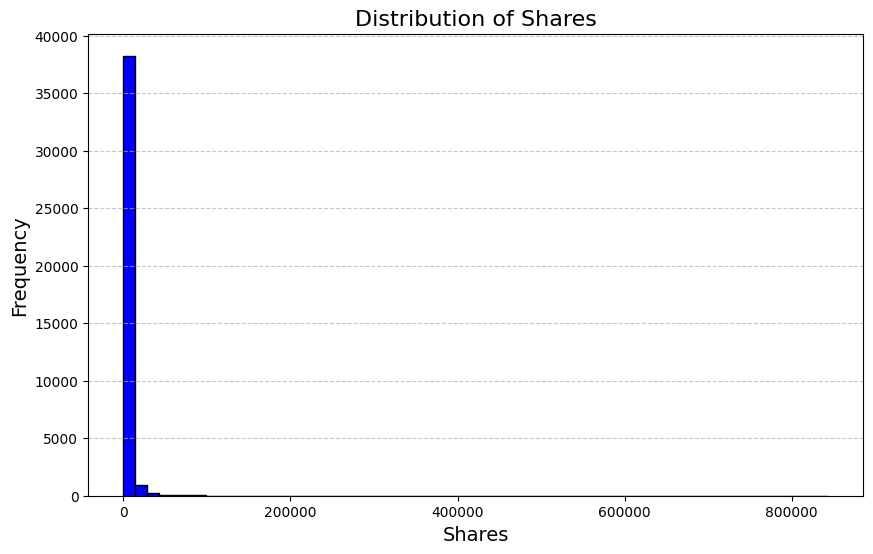

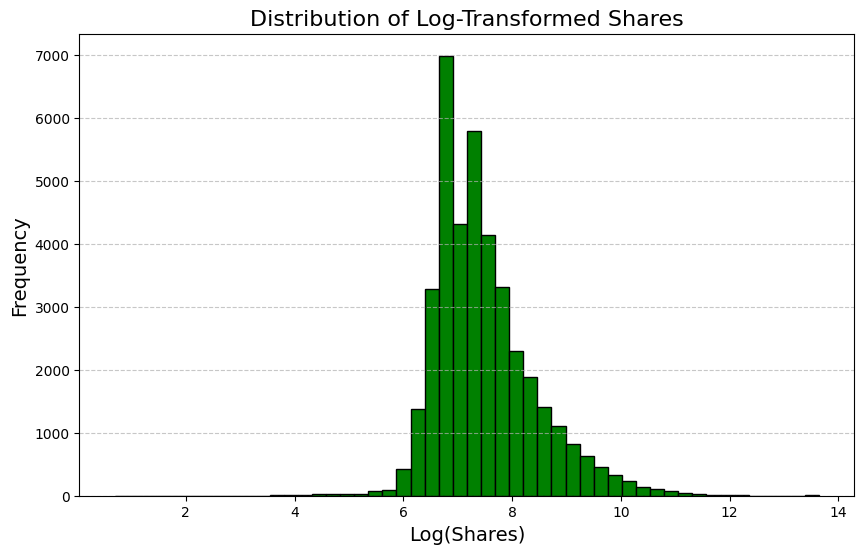

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

news_data = pd.read_csv("https://richardson.byu.edu/220/OnlineNewsPopularity.csv")

#It looked like each column had a ' ' character at the beginning of each word so i strip the spaces here.
news_data.columns = news_data.columns.str.strip()

plt.figure(figsize=(10, 6))
plt.hist(news_data['shares'], bins=60, color='blue', edgecolor='black')
plt.title('Distribution of Shares', fontsize=16)
plt.xlabel('Shares', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Log transformation to make the data less skewed
news_data['shares_log'] = np.log1p(news_data['shares'])

# Transformed data
plt.figure(figsize=(10, 6))
plt.hist(news_data['shares_log'], bins=50, color='green', edgecolor='black')
plt.title('Distribution of Log-Transformed Shares', fontsize=16)
plt.xlabel('Log(Shares)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()




### Linear Regression Modeling

### Regression Tree Modeling

# Technical Report

### Exploratory Data Analysis

### Linear Regression Modeling

### Regression Tree Modeling

### Conclusion